# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=\Omega_1 \cup \Omega_2$, with $\Omega_1=(0,1)\times(0, 1/4)$ and $\Omega_2=(0,1)\times(1/4,1)$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(0,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-z+1/4, (x,z) \in \Omega_1\\
-3, (x,z) \in \Omega_2
\end{array}
\end{array}
\right., 
\qquad \nu \cdot q = 0 \text{ on } \Gamma_N,
\qquad \psi(t,x,z) = -4 \text{ on } \Gamma_D,
\qquad f = 
\left\{
\begin{array}{ll}
\begin{array}{l} 
0, (x,z) \in \Omega_1\\
0.006 \cos(\frac{4}{3}\pi (z-1)) \sin(2\pi x), (x,z) \in \Omega_2
\end{array}
\end{array}
\right.
$$
and
$$
\Gamma_{D} = (0,1) \times \{1\},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "/workspaces/richards/")

import richards.exporter as exporter
import richards.model_params as model_params
import richards.matrix_computer as matrix_computer

In [3]:
K = 1000
N = 40
num_steps = 1

eps_psi_abs = 1e-7
eps_psi_rel = 0

domain_tolerance = 1 / (100 * N)

output_directory = 'output_evolutionary'

In [4]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [5]:
theta_r = 0.026
theta_s = 0.42

alpha = 0.95

n = 2.9
K_s = 0.12

T    = 0.01

In [6]:
h_s = 0
theta_m = theta_s
m = 1 - 1/n

In [7]:
dt   = (T-0)/num_steps

In [8]:
model_data = model_params.Model_Data(theta_r=theta_r, theta_s=theta_s, alpha=alpha, n=n, K_s=K_s, T=T, num_steps=num_steps)

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [9]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax1.plot(psi_val, model_data.theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K")

    ax3.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val))
    ax3.set_title("K^-1")

    ax4.plot(psi_val, model_data.theta(psi_val, 1))
    ax4.set_title("d theta / d psi")

    ax5.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val, 1))
    ax5.set_title("d (K) / d psi")

    ax6.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val, 1))
    ax6.set_title("d (K^-1) / d psi")


    plt.show()

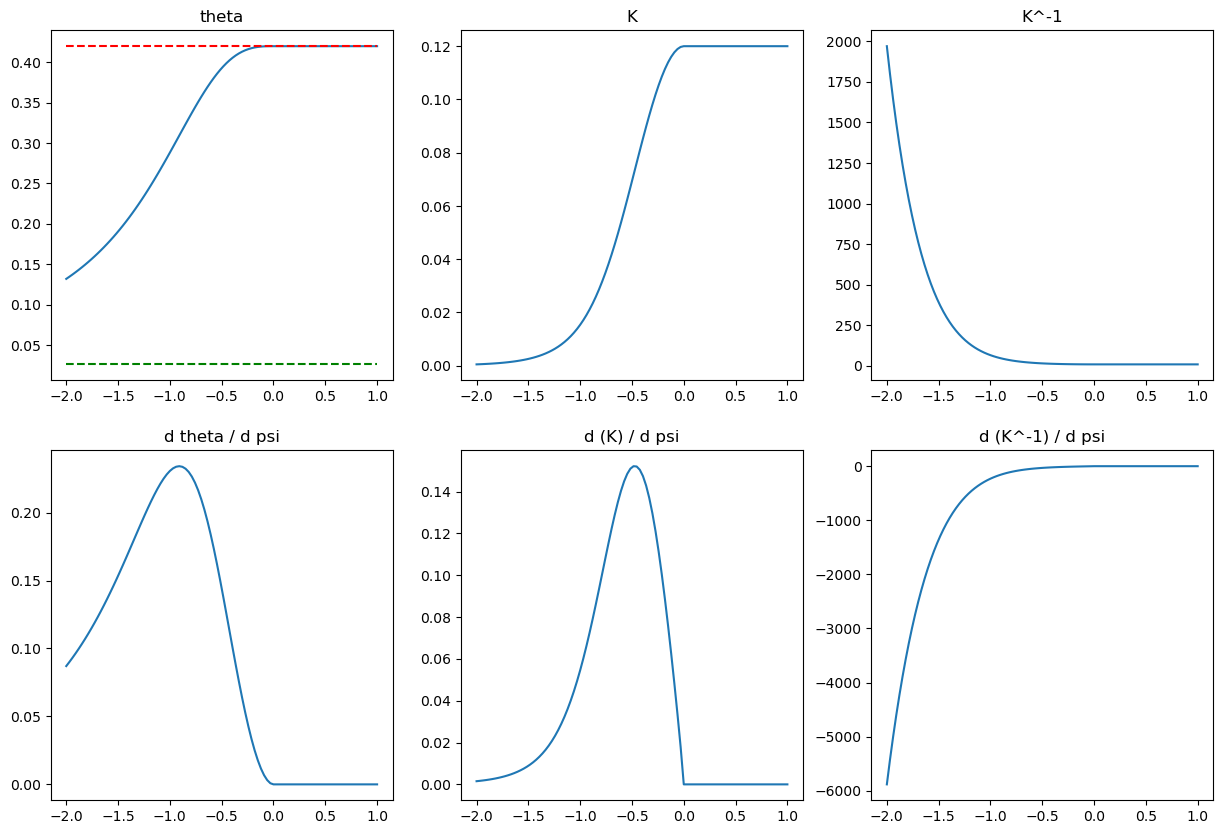

In [10]:
quick_plot()

### Domain preparation

In [11]:
subdomain = pp.StructuredTriangleGrid([N, N], [1,1])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [12]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []
initial_velocity = []

gravity = []

In [13]:
RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [14]:
def g_func(x): 
    return np.array([0, -1, -1])

In [15]:
def initial_pressure_func(x):
    if x[1] > 1/4 + domain_tolerance:
        return -3
    else:
        return -x[1]+1/4

In [16]:
def initial_velocity_func(x):
    if x[1] > 1/4 + domain_tolerance:
        return - model_data.hydraulic_conductivity_coefficient(np.array([-3])) * np.array([0,1,1])
    else:
        return np.zeros(shape=3)

In [17]:
def f(x,t):
    res = 0
    if x[1] > 1/4 + domain_tolerance:
        res = 0.006*np.cos(4/3*np.pi*(x[1]-1))*np.sin(2*np.pi*x[0])

    return res

In [18]:
for subdomain, data in mdg.subdomains(return_data=True):
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ RT0.interpolate(subdomain, g_func))
    
    initial_pressure.append( P0.interpolate(subdomain, initial_pressure_func))
    initial_velocity.append(RT0.interpolate(subdomain, initial_velocity_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d  = subdomain.face_centers[1, :] > 1-domain_tolerance
    gamma_n  = gamma_d.copy()
    
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    

    pp.initialize_data(subdomain, data, key, {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
    })
    
    def bc_gamma_d(x): return -4

    bc_value.append(- RT0.assemble_nat_bc(subdomain, bc_gamma_d, gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool) # No essential BC for pressure
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs))) # Essential BC for velocity on gamma_n

In [19]:
gamma_d.sum(), gamma_n.sum()

(40, 120)

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi^{n+1}_k) {q^{n+1}_{k+1}} + \nabla \psi^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}_{k+1}} = \frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k}^{n+1}}{\Delta t} + \frac{\theta (\psi^{n}) - \theta (\psi^{n+1}_k)}{\Delta t} + f^{n+1}
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [20]:
computer = matrix_computer.Matrix_Computer(mdg)

# get the degrees of freedom for each variable
dof_psi, dof_q = pg.div(mdg).shape

In [21]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)

In [22]:
def project_array_to_P0(val):
    return val * subdomain.cell_volumes

In [23]:
def picard(sol_n, t_n_1, iters=K, debug=False):
    prev = sol_n.copy()

    Mass_psi = computer.mass_matrix_P0()[0]
    B = computer.matrix_B()

    # Assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Theta^n
    fixed_rhs[-dof_psi:] += Mass_psi @ project_array_to_P0(model_data.theta(proj_psi @ prev[-dof_psi:])) / dt

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(bc_value)

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    # F
    fixed_rhs[-dof_psi:] += Mass_psi @ P0.interpolate(subdomain, lambda x: f(x, t_n_1))

    if debug:
        save_debug = exporter.Step_Exporter(mdg, "sol_" + str(t_n_1), output_directory + "/debug")
        save_debug.export( [prev] )

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):
        psi = prev[-dof_psi:]
        q   = prev[:dof_q]
        


        N = None
        N = Mass_psi @ np.diag(model_data.theta(proj_psi @ psi, 1))

        rhs = None
        rhs = fixed_rhs.copy()



        # Theta^{n+1}_k
        rhs[-dof_psi:] -= Mass_psi @ project_array_to_P0(model_data.theta(proj_psi @ psi)) / dt

        # Derivative Thetha^{n+1}_k
        rhs[-dof_psi:] += N @ psi / dt



        # Construct the local matrices
        M_k_n_1 = computer.mass_matrix_RT0_conductivity([pp.SecondOrderTensor(model_data.hydraulic_conductivity_coefficient(proj_psi @ psi))])
        
        spp = sps.bmat([[M_k_n_1,    B.T], 
                        [-B,      N / dt]], format="csc")

        

        # Solve the problem
        ls = None
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()



        if debug:
            save_debug.export( [current])




        abs_err_psi  = np.sqrt(np.sum(np.power(current[-dof_psi:] - psi, 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(psi, 2)))


        print('Iteration #' + format(k+1, '0' + str(ceil(log10(iters)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / eps_psi_abs)) + 4) + '.' + str(ceil(log10(1 / eps_psi_abs)) + 4) + 'f') )

        if abs_err_psi < eps_psi_abs + eps_psi_rel * abs_err_prev:
            break
        else:
            prev = None
            prev = current.copy()
            
    print('')
    return [current]

In [24]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [25]:
# assemble initial solution
initial_solution = np.zeros(dof_q + dof_psi)
initial_solution[-dof_psi:] += np.hstack(initial_pressure)
initial_solution[:dof_q]    += np.hstack(initial_velocity)

In [26]:
sol = [[initial_solution]]
step_exporter = exporter.Step_Exporter(mdg, "sol", output_directory)
step_exporter.export( sol[-1] )

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( picard(sol[-1][0], step * dt, debug=True) )
    step_exporter.export( sol[-1], step)

step_exporter.export_final_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.01
Iteration #0001, error L2 relative psi:    0.02644147860
Iteration #0002, error L2 relative psi:    0.08372792553
Iteration #0003, error L2 relative psi:    0.08219402123
Iteration #0004, error L2 relative psi:    0.06962372796
Iteration #0005, error L2 relative psi:    0.06959505393
Iteration #0006, error L2 relative psi:    0.06937651783
Iteration #0007, error L2 relative psi:    0.06937513168
Iteration #0008, error L2 relative psi:    0.06936458029
Iteration #0009, error L2 relative psi:    0.06936450590
Iteration #0010, error L2 relative psi:    0.06936393967
Iteration #0011, error L2 relative psi:    0.06936393552
Iteration #0012, error L2 relative psi:    0.06936390392
Iteration #0013, error L2 relative psi:    0.06936390367
Iteration #0014, error L2 relative psi:    0.06936390183
Iteration #0015, error L2 relative psi:    0.06936390182
Iteration #0016, error L2 relative psi:    0.06936390170
Iteration #0017, error L2 relative psi:    0.06936390170
Iteration #0018, erro

KeyboardInterrupt: 